In [1]:
import torch
import numpy as np
import datasets
import pickle
import pathlib
import os
from importlib import reload

from tqdm.auto import tqdm
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers.trainer_pt_utils import LengthGroupedSampler

from GlobEnc.src.modeling.modeling_bert_elementwise import BertForSequenceClassification
# from GlobEnc.src.modeling.modeling_electra import ElectraForSequenceClassification
# from GlobEnc.src.attention_rollout import AttentionRollout

2022-11-30 10:41:09.016647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 10:41:09.163114: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-30 10:41:09.884315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/modaresi/.conda/envs/globenc-venv/lib/
2022-11-30 10:41:09.884419: W tensorflow/

In [2]:
ROOT_DIR = "/home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise"
# MODELS = {
#     "sst2-e0": "bert-large-uncased",
#     "sst2-e1": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-2105",
#     "sst2-e2": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-4210",
#     "sst2-e3": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-6315",
#     "sst2-e4": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-8420",
#     "sst2-e5": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-10525",
# }
MODELS = {
#     "sst2-e0": "bert-base-uncased",
#     "sst2-e1": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-2105",
#     "sst2-e2": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-4210",
#     "sst2-e3": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-6315",
#     "sst2-e4": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-8420",
    "sst2-e5": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-base-uncased_0001_SEED0042/checkpoint-10525",
}
# MODELS = {
#     "mnli-e0": "bert-base-uncased",
#     "mnli-e1": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-12272",
#     "mnli-e2": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-24544",
#     "mnli-e3": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-36816",
#     "mnli-e4": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-49088",
#     "mnli-e5": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-61360",
# }
# MODELS = {
#     "cola-e0": "bert-base-uncased",
#     "cola-e1": "/home/modaresi/projects/globenc_analysis/outputs/models/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-268",
#     "cola-e2": "/home/modaresi/projects/globenc_analysis/outputs/models/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-536",
#     "cola-e3": "/home/modaresi/projects/globenc_analysis/outputs/models/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-804",
#     "cola-e4": "/home/modaresi/projects/globenc_analysis/outputs/models/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-1072",
#     "cola-e5": "/home/modaresi/projects/globenc_analysis/outputs/models/output_cola_bert-base-uncased_0001_SEED0042/checkpoint-1340",
# }
# MODELS = {
#     "mrpc-e0": "bert-base-uncased",
#     "mrpc-e1": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-115",
#     "mrpc-e2": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-230",
#     "mrpc-e3": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-345",
#     "mrpc-e4": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-460",
#     "mrpc-e5": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mrpc_bert-base-uncased_0001_SEED0042/checkpoint-575",
# }
# MODELS = {
#     "qnli-e0": "bert-base-uncased",
#     "qnli-e1": "/home/modaresi/projects/globenc_analysis/outputs/models/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-3274",
#     "qnli-e2": "/home/modaresi/projects/globenc_analysis/outputs/models/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-6548",
#     "qnli-e3": "/home/modaresi/projects/globenc_analysis/outputs/models/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-9822",
#     "qnli-e4": "/home/modaresi/projects/globenc_analysis/outputs/models/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-13096",
#     "qnli-e5": "/home/modaresi/projects/globenc_analysis/outputs/models/output_qnli_bert-base-uncased_0001_SEED0042/checkpoint-16370",
# }

# MULTI BERT
# MODELS = {
#     "multibert-qnli-s0": "google/multiberts-seed_0",
#     "multibert-qnli-s1": "google/multiberts-seed_1",
#     "multibert-qnli-s2": "google/multiberts-seed_2",
#     "multibert-qnli-s3": "google/multiberts-seed_3",
#     "multibert-qnli-s4": "google/multiberts-seed_4",
#     "multibert-qnli-s5": "google/multiberts-seed_5",
# }

# MODELS = {
#     "multibert-mrpc-s0": "google/multiberts-seed_0",
#     "multibert-mrpc-s1": "google/multiberts-seed_1",
#     "multibert-mrpc-s2": "google/multiberts-seed_2",
#     "multibert-mrpc-s3": "google/multiberts-seed_3",
#     "multibert-mrpc-s4": "google/multiberts-seed_4",
#     "multibert-mrpc-s5": "google/multiberts-seed_5",
# }

# MODELS = {
#     "multibert-cola-s0": "google/multiberts-seed_0",
#     "multibert-cola-s1": "google/multiberts-seed_1",
#     "multibert-cola-s2": "google/multiberts-seed_2",
#     "multibert-cola-s3": "google/multiberts-seed_3",
#     "multibert-cola-s4": "google/multiberts-seed_4",
#     "multibert-cola-s5": "google/multiberts-seed_5",
# }

# MODELS = {
#     "multibert-qnli-e0": "google/multiberts-seed_0-step_0k",
#     "multibert-qnli-e1": "google/multiberts-seed_0-step_400k",
#     "multibert-qnli-e2": "google/multiberts-seed_0-step_800k",
#     "multibert-qnli-e3": "google/multiberts-seed_0-step_1200k",
#     "multibert-qnli-e4": "google/multiberts-seed_0-step_1600k",
#     "multibert-qnli-e5": "google/multiberts-seed_0-step_2000k",
# }

# MODELS = {
#     "multibert-sst2-e0-20k": "google/multiberts-seed_0-step_0k",
#     "multibert-sst2-e1-20k": "google/multiberts-seed_0-step_20k",
#     "multibert-sst2-e2-20k": "google/multiberts-seed_0-step_40k",
#     "multibert-sst2-e3-20k": "google/multiberts-seed_0-step_60k",
#     "multibert-sst2-e4-20k": "google/multiberts-seed_0-step_80k",
#     "multibert-sst2-e5-20k": "google/multiberts-seed_0-step_100k",
# }

# MODELS = {
#     "multibert-sst2-e0-400k": "google/multiberts-seed_0-step_0k",
#     "multibert-sst2-e1-400k": "google/multiberts-seed_0-step_400k",
#     "multibert-sst2-e2-400k": "google/multiberts-seed_0-step_800k",
#     "multibert-sst2-e3-400k": "google/multiberts-seed_0-step_1200k",
#     "multibert-sst2-e4-400k": "google/multiberts-seed_0-step_1600k",
#     "multibert-sst2-e5-400k": "google/multiberts-seed_0-step_2000k",
# }

TASK = "sst2"
 
SET = "validation"  # train/validation/validation_matched
SAVE_CLS = True

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

BATCH_SIZE = 8
MAX_LENGTH = 128

actual_task = "mnli" if TASK == "mnli-mm" else TASK
dataset = datasets.load_dataset("glue", actual_task)
metric = datasets.load_metric('glue', actual_task)
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
SENTENCE1_KEY, SENTENCE2_KEY = task_to_keys[TASK]
dataset

Reusing dataset glue (/opt/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [4]:
def preprocess_function_wrapped(tokenizer):
    def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[SENTENCE1_KEY],) if SENTENCE2_KEY is None else (examples[SENTENCE1_KEY], examples[SENTENCE2_KEY])
        )
        result = tokenizer(*args, padding=False, max_length=MAX_LENGTH, truncation=True)
        return result
    return preprocess_function

def token_id_to_tokens_mapper(tokenizer, sample):
    length = len(sample["input_ids"])
    return tokenizer.convert_ids_to_tokens(sample["input_ids"])[:length], length

In [5]:
path = MODELS["sst2-e5"]
model = BertForSequenceClassification.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path, use_fast=True, max_length=MAX_LENGTH)

sel_dataset = dataset[SET].map(preprocess_function_wrapped(tokenizer), batched=True, batch_size=1024)
dataset_size = len(sel_dataset)
steps = int(np.ceil(dataset_size / BATCH_SIZE))

Parameter 'function'=<function preprocess_function_wrapped.<locals>.preprocess_function at 0x7fe2910a5b90> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
globencs = {"globenc": [], "tokens": [], "cls": []}
lengths = []

for i in tqdm(range(dataset_size), desc="Tokenize"):
    tokens, length = token_id_to_tokens_mapper(tokenizer, sel_dataset[i])
    globencs["tokens"].append(tokens)
    lengths.append(length)

Tokenize:   0%|          | 0/872 [00:00<?, ?it/s]

In [7]:
sel_dataset = sel_dataset.add_column("length", lengths)
sel_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "length", "idx"])

In [22]:
N = 256
sims_mean = np.zeros((N, 12))
sims_mean_tokens = np.zeros((N, 12))
sims_cls = np.zeros((N, 12))
sims_sep = np.zeros((N, 12))
for idx in tqdm(range(N)):
    with torch.no_grad():
        batch = sel_dataset[idx]
        input_batch = {k: batch[k].unsqueeze(dim=0) for k in ["input_ids", "token_type_ids", "attention_mask"]}
        logits, hidden_states, norms, attribution_vectors = model(**input_batch, output_attentions=False, output_norms=False, 
                                                        return_dict=False, output_globenc=True, output_hidden_states=True, output_globenc_vectors=True)
        for l in range(12):
            all_sims = torch.nn.functional.cosine_similarity(hidden_states[l+1][0], attribution_vectors[l][0].sum(dim=1), dim=-1)
            sims_mean_tokens[idx, l] = all_sims[1:-1].mean().numpy()
            sims_mean[idx, l] = all_sims.mean().numpy()
            sims_cls[idx, l] = all_sims[0].numpy()
            sims_sep[idx, l] = all_sims[-1].numpy()

  0%|          | 0/256 [00:00<?, ?it/s]

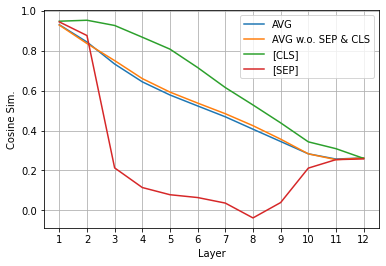

In [24]:
import matplotlib.pyplot as plt
plt.plot(sims_mean.mean(axis=0), label="AVG")
plt.plot(sims_mean_tokens.mean(axis=0), label="AVG w.o. SEP & CLS")
plt.plot(sims_cls.mean(axis=0), label="[CLS]")
plt.plot(sims_sep.mean(axis=0), label="[SEP]")
plt.xlabel("Layer")
plt.xticks(np.arange(0,12),np.arange(1,13))
plt.ylabel("Cosine Sim.")
plt.legend()
plt.grid("on")
plt.show()

In [35]:
N = 100
sims_mean = np.zeros((N, 12))
sims_mean_tokens = np.zeros((N, 12))
sims_cls = np.zeros((N, 12))
sims_sep = np.zeros((N, 12))
for idx in tqdm(range(N)):
    with torch.no_grad():
        batch = sel_dataset[idx]
        input_batch = {k: batch[k].unsqueeze(dim=0) for k in ["input_ids", "token_type_ids", "attention_mask"]}
        logits, hidden_states, norms, attribution_vectors = model(**input_batch, output_attentions=False, output_norms=False, 
                                                        return_dict=False, output_globenc=True, output_hidden_states=True, output_globenc_vectors=True)
        for l in range(12):
            all_sims = torch.nn.functional.cosine_similarity(model.bert.encoder.layer[l].output.LayerNorm.bias, attribution_vectors[l][0].sum(dim=1), dim=-1).abs()
            sims_mean_tokens[idx, l] = all_sims[1:-1].mean().numpy()
            sims_mean[idx, l] = all_sims.mean().numpy()
            sims_cls[idx, l] = all_sims[0].numpy()
            sims_sep[idx, l] = all_sims[-1].numpy()

  0%|          | 0/100 [00:00<?, ?it/s]

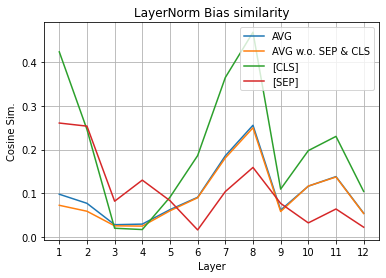

In [36]:
import matplotlib.pyplot as plt
plt.plot(sims_mean.mean(axis=0), label="AVG")
plt.plot(sims_mean_tokens.mean(axis=0), label="AVG w.o. SEP & CLS")
plt.plot(sims_cls.mean(axis=0), label="[CLS]")
plt.plot(sims_sep.mean(axis=0), label="[SEP]")
plt.xlabel("Layer")
plt.xticks(np.arange(0,12),np.arange(1,13))
plt.ylabel("Cosine Sim.")
plt.legend()
plt.grid("on")
plt.title("LayerNorm Bias similarity")
plt.show()